Features_df importieren

In [106]:
import pandas as pd

features_df = pd.read_pickle("../data/processed/features.pkl")

X definieren

In [107]:
X = features_df[['month_sin',
                 'month_cos',
                 'day_of_week_sin',
                 'day_of_week_cos',
                 'minute_of_day_sin',
                 'minute_of_day_cos',
                 'wind_dir_sin',
                'wind_dir_cos',
                'wind_speed_kt',
                'is_wind_variable',
                'vis_ge_10km',
                'vis_category',
                'temperature_c',
                'spread_c',
                'qnh_hpa',
                'is_holiday',
                'scheduled_departures',
                'scheduled_arrivals',
                'avg_dep_delay_prev_slot_minutes',
                'avg_dep_delay_past_6h_minutes',
                'scheduled_B',
                'scheduled_C',
                'scheduled_D',
                'scheduled_E',
                'scheduled_F',
                'scheduled_rwy_concept',
                'arr_dep_ratio',
        ]]

Y definieren

In [108]:
y = features_df[['avg_dep_delay_slot_minutes']]

XGBoost und train_test_split importieren

In [109]:
import xgboost
from sklearn.model_selection import train_test_split

Daten in Trainings-, Validations- und Testset aufteilen

In [110]:
X_train, X_temp, y_train, y_temp = train_test_split(X,y,test_size=0.4,random_state=42,shuffle=False)
X_test, X_val, y_test, y_val = train_test_split(X_temp,y_temp,test_size=0.5,random_state=42,shuffle=False) 

'''
Daten werden aufgesplittet:
- 60% Training
- 20% Validierung
- 20% Test
'''

'\nDaten werden aufgesplittet:\n- 60% Training\n- 20% Validierung\n- 20% Test\n'

XGBRegressor importieren

In [111]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit

Hyperparamter-Tuning mit RandomizedSearchCV anhand vom Trainingsset

In [112]:
param_grid = {
    "max_depth": [4, 6, 8, 10],
    "min_child_weight": [1, 3, 5],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
    "gamma": [0, 1, 2],
    "reg_alpha": [0, 0.1, 0.5],
    "reg_lambda": [1, 2, 5],
    "learning_rate": [0.05, 0.1],
    "n_estimators": [3000]
}

model = XGBRegressor(
    objective = 'reg:squarederror',
    enable_categorical = True,
    random_state = 42,
    early_stopping_rounds = 50,
    n_jobs = -1
)

tscv = TimeSeriesSplit(n_splits=4, gap=4*24)

'''
You have 30-minute slots → 48 slots = 1 day

Use TimeSeriesSplit to respect time order

Optionally leave a gap (e.g. 2–3 days) to avoid leakage

Perfect for tuning, since it checks the model across multiple time periods
'''

search = RandomizedSearchCV(
    model,
    param_distributions=param_grid,
    scoring='r2',
    cv=tscv,
    n_iter=20,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

search.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=0)
print(search.best_params_)

Fitting 4 folds for each of 20 candidates, totalling 80 fits
{'subsample': 0.8, 'reg_lambda': 2, 'reg_alpha': 0.5, 'n_estimators': 3000, 'min_child_weight': 5, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 2, 'colsample_bytree': 0.8}


Optimierte Hyperparameter ins Modell einfügen

In [113]:
model = XGBRegressor(
    objective='reg:squarederror',
    enable_categorical=True,
    random_state=42,
    n_jobs=-1,
    early_stopping_rounds=50,
    subsample=0.8,
    reg_lambda=2,
    reg_alpha=0.5,
    n_estimators=3000,
    min_child_weight=5,
    max_depth=4,
    learning_rate=0.1,
    gamma=2,
    colsample_bytree=0.8
)

In [114]:
model.fit(X_train,y_train,eval_set=[(X_val,y_val)],verbose=0)

''' 
Modell aufgrund der Trainingsdaten trainieren.
Nach jeder Iteration wird überprüft, wie sich das Modell auf dem Validationsset verhält.
Wenn sich der Fehler auf dem Validationset für 50 Iterationen in Folge nicht verbessert, wird das Training abgebrochen (early stopping).
'''

' \nModell aufgrund der Trainingsdaten trainieren.\nNach jeder Iteration wird überprüft, wie sich das Modell auf dem Validationsset verhält.\nWenn sich der Fehler auf dem Validationset für 50 Iterationen in Folge nicht verbessert, wird das Training abgebrochen (early stopping).\n'

Statistische Tests importieren

In [115]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

Trainiertes Modell am Validation-Set anwenden

In [116]:
y_pred_val = model.predict(X_val)

Mean Absolute Error (MAE)

In [117]:
mae_y_val = mean_absolute_error(y_val,y_pred_val)
print("Mean Absolute Error (MAE) on Validation Set:", mae_y_val, "minutes")

Mean Absolute Error (MAE) on Validation Set: 5.119167804718018 minutes


Root Mean Square Error (RMSE)

In [118]:
rmse_y_val = root_mean_squared_error(y_val,y_pred_val)
print("Root Mean Square Error (RMSE) on Validation Set:", rmse_y_val, "minutes")

Root Mean Square Error (RMSE) on Validation Set: 10.433990478515625 minutes


R^2 Score

In [119]:
r2_y_val = r2_score(y_val,y_pred_val)
print("R^2 Score on Validation Set:", r2_y_val)


R^2 Score on Validation Set: 0.5080985426902771


Scores als CSV abspeichern

In [ ]:
'''baseline_scores_v3 = {
    "MAE": mae_y_val,
    "RMSE": rmse_y_val,
    "R^2": r2_y_val
}
print(baseline_scores_v3)
baseline_df = pd.DataFrame([baseline_scores_v3])
baseline_df.to_csv("../data/processed/baseline_model_scores_v3.0.csv")
'''

{'MAE': 5.119167804718018, 'RMSE': 10.433990478515625, 'R^2': 0.5080985426902771}


Feature Importance

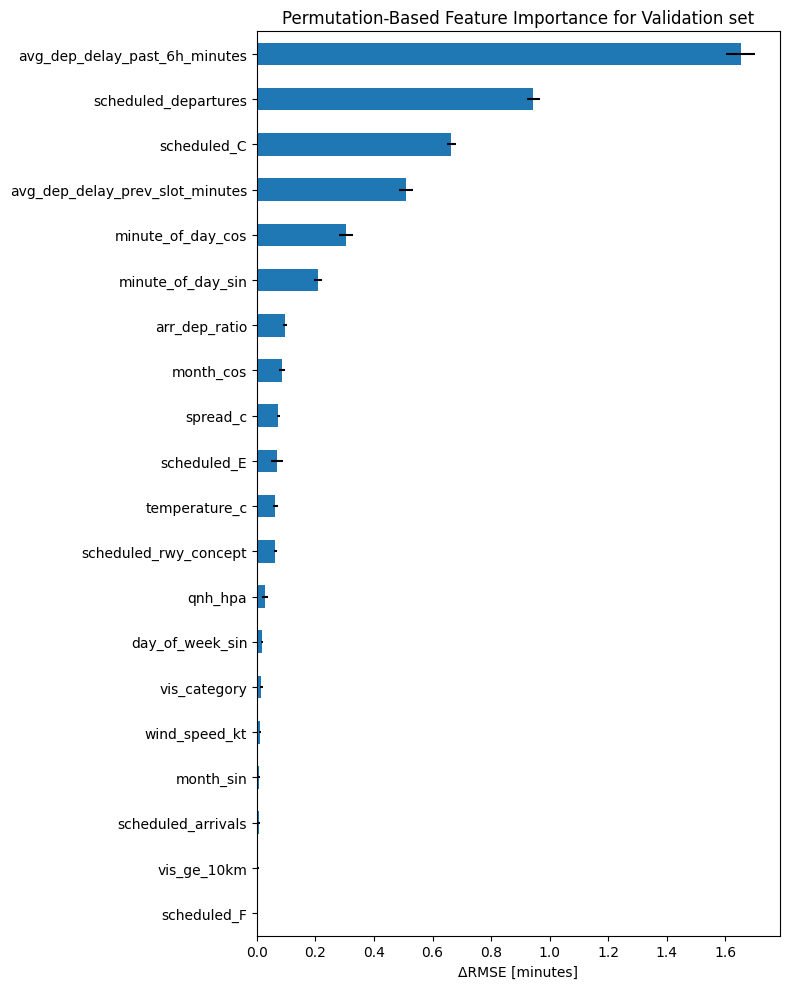

In [121]:
from sklearn.inspection import permutation_importance
import numpy as np
import matplotlib.pyplot as plt

# Ensure y is 1-D
y_val_1d = y_val.values.ravel()  # if y_val is a 1-col DataFrame

r = permutation_importance(
    model, X_val, y_val_1d,
    n_jobs=-1,
    n_repeats=100,
    random_state=42,
    scoring="neg_root_mean_squared_error"
)

# Build Series so indices align with feature names
imp_mean = pd.Series(r.importances_mean, index=X_val.columns).sort_values(ascending=False)
imp_std  = pd.Series(r.importances_std,  index=X_val.columns).reindex(imp_mean.index)

plt.figure(figsize=(8,10))
imp_mean.head(20).plot(
    kind="barh",
    xerr=imp_std.head(20).values  # pass values to xerr
)
plt.gca().invert_yaxis()
plt.xlabel("ΔRMSE [minutes]")
plt.title("Permutation-Based Feature Importance for Validation set")
plt.tight_layout()
plt.show()


Predicted vs Actual Delays Validaiton Set

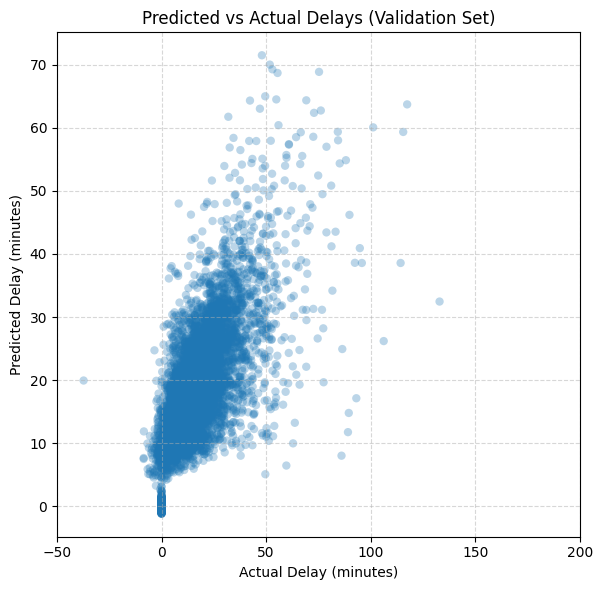

In [124]:
# Ensure Series alignment
y_true = y_val.squeeze()     # actual delays
y_pred = model.predict(X_val)

plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred, alpha=0.3, edgecolor='none')
plt.xlabel("Actual Delay (minutes)")
plt.ylabel("Predicted Delay (minutes)")
plt.title("Predicted vs Actual Delays (Validation Set)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.xlim(-50, 200)
plt.show()


Residual Distribution (Residuals vs Predicted Delay)

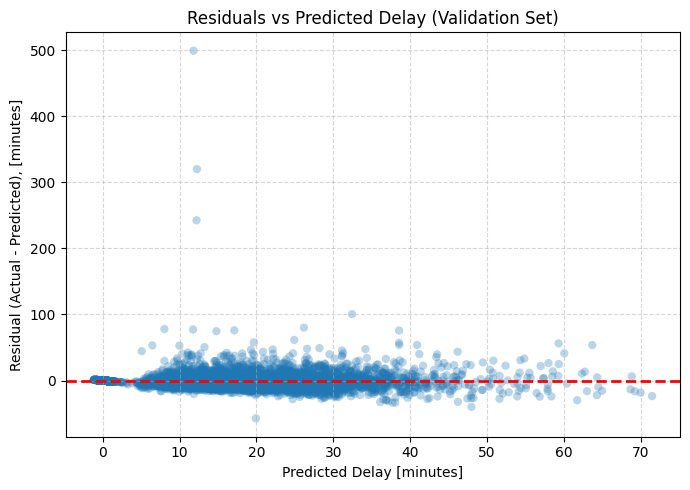

In [133]:
# Predicted and actual values
y_true = y_val.squeeze()
y_pred = model.predict(X_val)

# Residuals
residuals = y_true - y_pred

plt.figure(figsize=(7,5))
plt.scatter(y_pred, residuals, alpha=0.3, edgecolor='none')
plt.axhline(0, color="red", linestyle="--", lw=2)
plt.title("Residuals vs Predicted Delay (Validation Set)")
plt.xlabel("Predicted Delay [minutes]")
plt.ylabel("Residual (Actual - Predicted), [minutes]")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


Residual Distribution (Residuals vs Actual Delay)

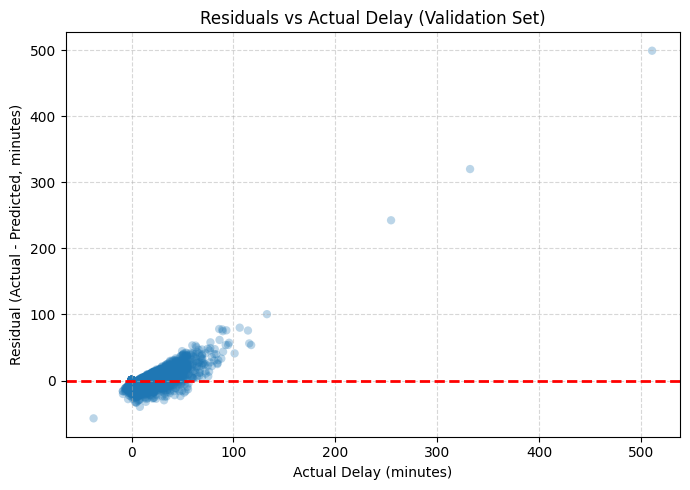

In [137]:
# 1) Make y_val a 1-D Series
y_true = y_val.squeeze()            # or: y_val.iloc[:, 0]

# 2) Make predictions and wrap in a Series with the same index
y_pred = pd.Series(model.predict(X_val), index=y_true.index)

# 3) Residuals
residuals = y_true - y_pred

# 4) Residuals vs ACTUAL plot
plt.figure(figsize=(7,5))
plt.scatter(y_true, residuals, alpha=0.3, edgecolor='none')
plt.axhline(0, color="red", linestyle="--", lw=2)
plt.title("Residuals vs Actual Delay (Validation Set)")
plt.xlabel("Actual Delay (minutes)")
plt.ylabel("Residual (Actual - Predicted, minutes)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()
